## GSE263713 – Fibroblasts as an in vitro model of circadian genetic and genomic studies: A temporal analysis (RNA-Seq)

- https://pmc.ncbi.nlm.nih.gov/articles/PMC11329553/

In [2]:
import COFE.analyse
import COFE.scpca
import COFE.plot
import numpy as np
import anndata as ad
import pandas as pd
import PCA_func as pc
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

### Step 1: Open the dataset

In [5]:
path = '/Users/maksimsgolubovics/Python_VScode/Studienprojekt/rnaseq_datasets/GSE263713_rnaseq.h5ad'
adata = ad.read_h5ad(path)

#Transform to DataFrame
data_df = pd.DataFrame(data=normalize(adata.X, axis=0)*1000000, columns=adata.var.index, index=adata.obs.index).T

#Look at sampeles features
adata.var[['tissue', 'cell_type', 'treatment', 'time']].head()
adata.var['type']
adata.var['subject'] = adata.var['title'].str.extract(r'(\d+)')

### Step 2: Prepare the dataset

In [6]:
data_df_log = np.log10(data_df + 0.1) #Logarithmic transformation

### Step 3: Exploratory analysis

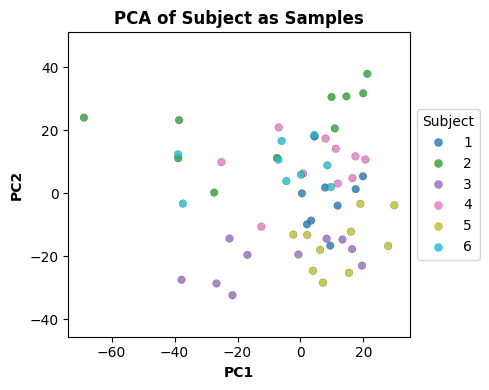

In [7]:
data_df_log_time = data_df_log.join(adata.var['subject']).reset_index().set_index('subject').drop('index', axis=1)
pc.principal_component_2d_timesample(data=data_df_log_time, label='Subject', c_map='tab10')

### Step 4: Identify mean and std threshold values

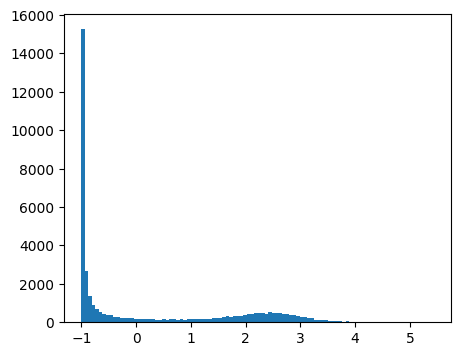

In [8]:
plt.figure(figsize=(5, 4))
plt.hist(x=data_df_log.mean(), bins=100);

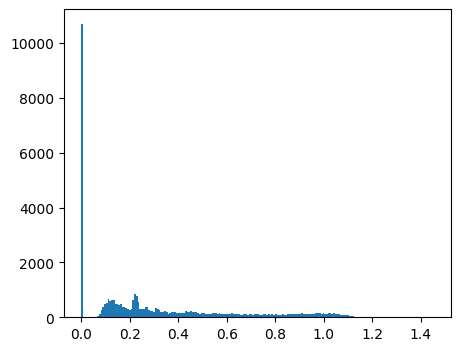

In [9]:
plt.figure(figsize=(5, 4))
plt.hist(x=data_df_log.std(), bins=200);

### Step 5: Batch Effect

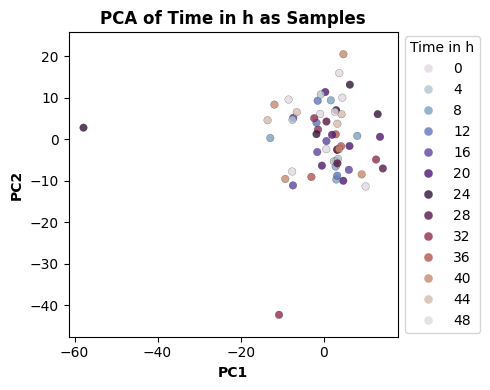

In [10]:
residual = pc.residual_dummy(data=data_df_log.T[data_df_log.mean()>=1].T, data_dummy_1=adata.var['subject'], columns=['subject'])
residual_time = residual.join(adata.var['time']).reset_index().set_index('time').drop('index', axis=1)
pc.principal_component_2d_timesample(data=residual_time, label='Time in h', c_map='twilight')

## COFE

### Strong Reduction

In [32]:
X_train_a = residual
true_time_train_a = adata.var['time'].astype(int)

X_train_a, X_test_a, features_a, features_std_a = COFE.analyse.preprocess_data(X_train_a.to_numpy(), None, 
                                                                           features=X_train_a.columns, feature_dim='col',
                                                                           mean_threshold=-1, scaling_threshold=3)
X_train_a.shape # (Samples, Transcripts)

(58, 2262)

In [35]:
s_choices = np.linspace(1, 70, 15)
cv_a = COFE.analyse.cross_validate(X_train_a, s_choices, features=features_a, K=5, ncores=-1, restarts=10)

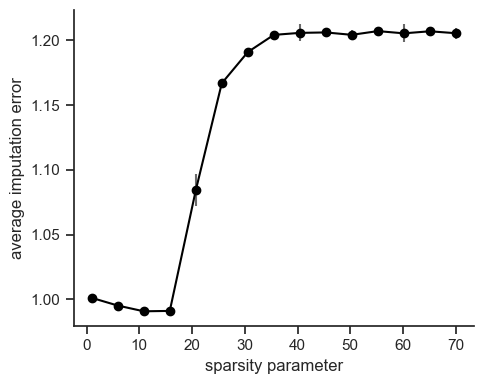

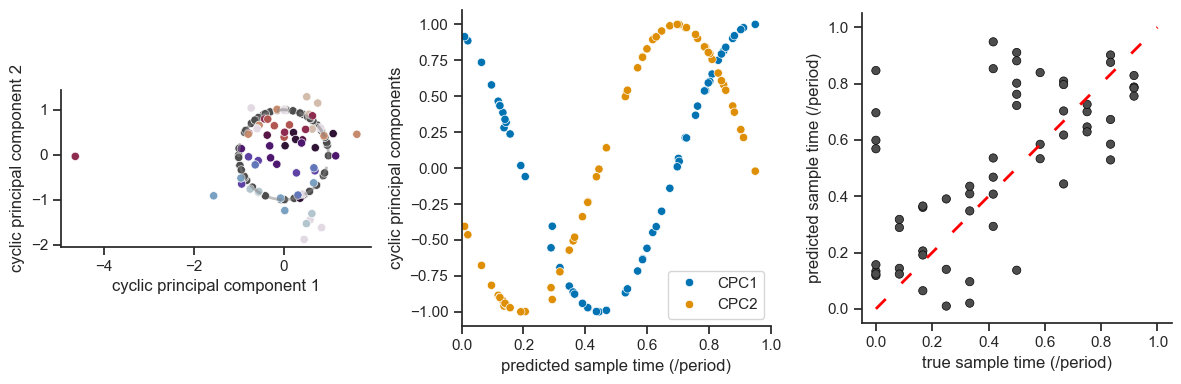

In [36]:
results_train_diet_a = COFE.analyse.predict_time(X_train_a, cv_a, true_times=true_time_train_a.to_numpy(), period=48)
COFE.plot.plot_cv_run(results_train_diet_a, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_a, time=true_time_train_a.to_numpy(), X=X_train_a, figsize=(12, 4), period=48)

In [37]:
results_train_diet_a["MAPE"]*24

np.float64(3.191111263534566)

### Smaller Reduction

In [24]:
X_train_b = residual
true_time_train_b = adata.var['time'].astype(int)

X_train_b, X_test_b, features_b, features_std_b = COFE.analyse.preprocess_data(X_train_b.to_numpy(), None, 
                                                                           features=X_train_b.columns, feature_dim='col',
                                                                           mean_threshold=-1, scaling_threshold=7)
X_train_b.shape # (Samples, Transcripts)

(58, 7004)

In [25]:
s_choices = np.linspace(1, 70, 15)
cv_b = COFE.analyse.cross_validate(X_train_b, s_choices, features=features_b, K=5, ncores=-1, restarts=10)

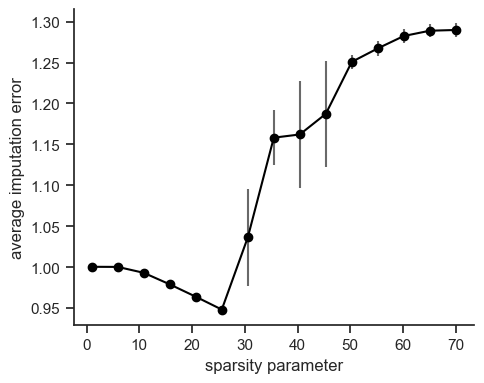

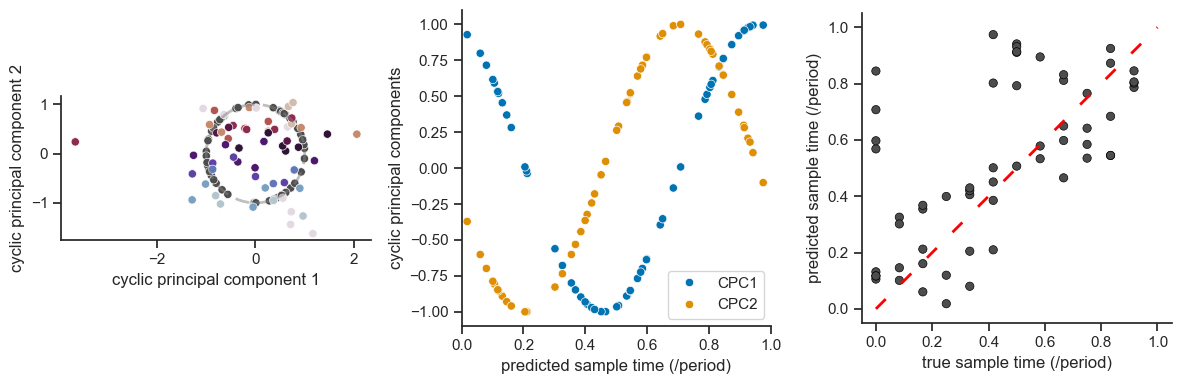

In [26]:
results_train_diet_b = COFE.analyse.predict_time(X_train_b, cv_b, true_times=true_time_train_b.to_numpy(), period=48)
COFE.plot.plot_cv_run(results_train_diet_b, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_b, time=true_time_train_b.to_numpy(), X=X_train_b, figsize=(12, 4), period=48)

In [27]:
results_train_diet_b["MAPE"]*24

np.float64(3.1454113815201463)

## Conclusion
- We used a cubic spline regression model to identify genes that had a significant effect of time in their expression (Wang et al. 2003; Qin and Guo 2006; Madden et al. 2017). This approach identified n = 2767 (~ 25%) genes with significant evidence (False discovery rate (FDR) < 0.05) for temporal changes of gene expression levels.
- Out of the 1439 circadian genes reported in that study, we identified 267 genes in our dataset with significant changes in expression over time (Fig. 2A).
-  only JTK and ARSER identified significant periodic expression patterns (after Benjamini–Hochberg correction of 0.05) for the circadian gene NR1D2, and further only ARSER identified significant oscillations for 73 genes.
- From the longitudinal RNA-seq data we identified consistent circadian patterns of expression in a limited amount of genes such as ARNTL, CRY1, PER3, NR1D2 (Rev-erbBeta) and TEF, but observed noticeable differences in the expression patterns between cell cultures.

In this study, COFE shows strangely interesting results where the large reduction in feature space improves the result, but obviously the deviation in prediction is still large. Perhaps the way the researcher approached the synchronization and treatment of the cell cultures influenced the results.